In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as spsg
import scipy.special as special
import statistics as stat

In [2]:
def sigmoid(x):
    return 1/(1+special.expit(-x))

class CTRNN():

    def __init__(self,duration,dt):
        size = 3
        self.Size = size                        # number of neurons in the circuit
        self.States = np.zeros(size)            # state of the neurons
        self.TimeConstants = np.ones(size)      # time-constant for each neuron
        self.invTimeConstants = 1.0/self.TimeConstants
        self.Biases = np.zeros(size)            # bias for each neuron
        self.Weights = np.zeros((size,size))    # connection weight for each pair of neurons
        self.Outputs = np.zeros(size)           # neuron outputs
        self.Inputs = np.zeros(size)            # external input to each neuron
        self.time = np.arange(0.0,duration,dt)
        self.TimeSeries = np.zeros((len(self.time),3))
        self.dt = dt
        

    def updateInput(self,inputvals):
        self.Inputs = inputvals
    
    def setWeights(self, weights):
        self.Weights =  weights

    def setBiases(self, biases):
        self.Biases =  biases

    def setTimeConstants(self, timeconstants):
        self.TimeConstants =  timeconstants
        self.invTimeConstants = 1.0/self.TimeConstants

    def randomizeParameters(self):
        self.Weights = np.random.uniform(-10,10,size=(self.Size,self.Size))
        self.Biases = np.random.uniform(-10,10,size=(self.Size))
        self.TimeConstants = np.random.uniform(0.1,5.0,size=(self.Size))
        self.invTimeConstants = 1.0/self.TimeConstants

    def initializeState(self, s):
        self.States = s
        self.Outputs = sigmoid(self.States+self.Biases)

    def step(self):
        netinput = self.Inputs + np.dot(self.Weights.T, self.Outputs)
        self.States += self.dt * np.multiply(self.invTimeConstants,(-self.States+netinput))
        self.Outputs = sigmoid(self.States+self.Biases)

In [3]:
##Two-legged walker with interneuron and tonic input to interneuron

# Constants
LegLength = np.array([15,15])
MaxLegForce = 0.05
ForwardAngleLimit = math.pi/6.0
BackwardAngleLimit = -math.pi/6.0
MaxVelocity = 6.0
MaxTorque = 0.5
MaxOmega = 1.0

class LeggedAgent:

    def __init__(self,l,stepsize,duration):   #n= number of legs, l=2 for me
        self.legs = l
        self.ix = 0.0
        self.iy = 0.0
        self.cx = 0.0
        self.cy = 0.0
        self.vx = 0.0
        self.footstate = np.zeros(l)
        self.angle = np.repeat(np.array(ForwardAngleLimit),l)
        self.omega = np.zeros(l)
        self.forwardForce = np.zeros(l)
        self.backwardForce = np.zeros(l)
        self.jointX = np.repeat(self.cx,l)
        self.jointY = np.repeat(self.cy + 12.5,l)
        self.footX = self.jointX + LegLength * np.sin(self.angle)
        self.footY = self.jointY + LegLength * np.cos(self.angle)
        self.stepsize = stepsize

    def state(self):
        return np.array([self.angle, self.omega, self.footstate])

    def out(self):
        return np.array([self.angle * 5.0/ForwardAngleLimit])

    def walkstep(self, u):
        #print("Walkstep")
        force = np.zeros(self.legs)
        for i in range(self.legs):
            # Update the leg effectors
            if (u[i] > 0.5):
                self.footstate[i] = 1
                self.omega[i] = 0
                self.forwardForce[i] = 2 * (u[i] - 0.5) * MaxLegForce;
                self.backwardForce[i] = 0.0
            else:
                self.footstate[i] = 0
                self.forwardForce[i] = 0.0
                self.backwardForce[i] = 2 * (0.5 - u[i]) * MaxLegForce;

        # Compute force applied to the body
        for i in range(self.legs):
            f = self.forwardForce[i] - self.backwardForce[i]
            if self.footstate[i] == 1.0:
                if ((self.angle[i] >= BackwardAngleLimit and self.angle[i] <= ForwardAngleLimit) or
                    (self.angle[i] < BackwardAngleLimit and f < 0) or
                    (self.angle[i] > ForwardAngleLimit and f > 0)):
                    force[i] = f
        totalforce = sum(force)

        # Update the position of the body
        self.vx = self.vx + self.stepsize * totalforce
        if (self.vx < -MaxVelocity):
            self.vx = -MaxVelocity
        if (self.vx > MaxVelocity):
            self.vx = MaxVelocity
        self.cx = self.cx + self.stepsize * self.vx
        
        # Update the leg geometry
        for i in range(self.legs):
            self.jointX[i] = self.jointX[i] + self.stepsize * self.vx
            if (self.footstate[i] == 1.0):
                angle = math.atan2(self.footX[i] - self.jointX[i], self.footY[i] - self.jointY[i])
                self.omega[i] = (angle - self.angle[i])/self.stepsize
                self.angle[i] = angle
            else:
                self.vx = 0.0
                self.omega[i] = self.omega[i] + self.stepsize * MaxTorque * (self.backwardForce[i] - self.forwardForce[i])
                if (self.omega[i] < -MaxOmega):
                    self.omega[i] = -MaxOmega
                if (self.omega[i] > MaxOmega):
                    self.omega[i] = MaxOmega
                self.angle[i] = self.angle[i] + self.stepsize * self.omega[i]
                if (self.angle[i] < BackwardAngleLimit):
                    self.angle[i] = BackwardAngleLimit
                    self.omega[i] = 0
                if (self.angle[i] > ForwardAngleLimit):
                    self.angle[i] = ForwardAngleLimit
                    self.omega[i] = 0
                self.footX[i] = self.jointX[i] + LegLength[i] * math.sin(self.angle[i])
                self.footY[i] = self.jointY[i] + LegLength[i] * math.cos(self.angle[i])

        # If any foot is too far back, the body becomes "unstable" and forward motion ceases
        for i in range(self.legs):
            if (self.cx - self.footX[i] > 20):
                self.vx = 0.0
        
    
    def run(self,duration,n,inputarray):
        self.ctrnn_record = np.zeros((self.legs+1,len(inputarray[0])))
        self.walker_record = np.zeros(len(inputarray[0]))
        self.timeseries = np.arange(0,duration,self.stepsize)
        for t in range(len(self.timeseries)):
            n.updateInput(inputarray[:,t])  
            n.step()
            self.walkstep(n.Outputs)
            self.ctrnn_record[:,t] = n.Outputs
            self.walker_record[t] = self.cx
                
                
            

In [4]:
#Phase only makes sense if there is oscillation, so how do we make sure there is oscillation before doing this analysis
#first evolve a population of walkers,then from there you can evaluate for phase?
#Clean transients out of timeseries (both at start and after current step)

def clean(timeseries, transientlen):
    #print("cleaning timeseries")
    inputdivision = int(len(timeseries)/2)
    firsthalf = timeseries[:inputdivision]
    lasthalf = timeseries[inputdivision:]
    cln_firsthalf = firsthalf[transientlen:]
    cln_lasthalf = lasthalf[transientlen:]
    return cln_firsthalf, cln_lasthalf

In [5]:
#phase analysis on half-timeseries without transients
def avgphase(l_timeseries,r_timeseries):
    #print("calc phase shift")
    timederivs = np.array([np.diff(l_timeseries)/stepsize,np.diff(r_timeseries)/stepsize])
    num_cycles1 = len(spsg.find_peaks(timederivs[0],prominence = .0005)[0])
    num_cycles2 = len(spsg.find_peaks(timederivs[1],prominence = .0005)[0]) 
    if num_cycles1 <= 1 or num_cycles2<=1:
        return 100
    else:
        #print(num_cycles1,num_cycles2)
        num_cycles = min([num_cycles1,num_cycles2])
        onset_times = np.zeros((2,num_cycles))
        for i in range(2):
            onset_times[i]= spsg.find_peaks(timederivs[i],prominence = .0005)[0][:num_cycles]
            onset_times[i] = onset_times[i]*stepsize
        
        #print(onset_times)
        period = stat.mean([onset_times[0,1]-onset_times[0,0],onset_times[1,1]-onset_times[1,0]])
        shifted_onset_times = np.zeros(num_cycles)
          
        for j in range(len(onset_times[0])):
            shifted_onset_times[j] = onset_times[1,j] - onset_times[0,j]

        phases = shifted_onset_times/period
        avg_phase = np.average(phases)
        return avg_phase
            
def fitnesscalc(l_0,l_i,r_0,r_i,w_0,w_i):
    #print("calculating fitness")
    phase0 = avgphase(l_0,r_0)
    phasei = avgphase(l_i,r_i)
    if phase0 == 100 or phasei == 100:
        return -1
    else:
        speed0 = (w_0[-1]-w_0[0])/duration
        speedi = (w_i[-1]-w_i[0])/duration
        fitness = speed0*(1-2*abs(.5-phase0))+speedi*(2*abs(.5-phasei))
        return fitness
            

In [6]:
#Evolutionary algorithm:
class Microbial():

    def __init__(self, fitnessFunction, popsize, genesize, recombProb, mutatProb, generations):
        self.fitnessFunction = fitnessFunction
        self.popsize = popsize
        self.genesize = genesize
        self.recombProb = recombProb
        self.mutatProb = mutatProb
        self.generations = generations
        self.tournaments = generations*popsize
        self.pop = np.random.rand(popsize,genesize)*2 - 1
        self.fitness = np.zeros(popsize)
        self.avgHistory = np.zeros(generations)
        self.bestHistory = np.zeros(generations)
        self.gen = 0

    def showFitness(self):
        plt.plot(self.bestHistory)
        plt.plot(self.avgHistory)
        plt.xlabel("Generations")
        plt.ylabel("Fitness")
        plt.title("Best and average fitness")
        plt.show()

    def fitStats(self):
        bestind = self.pop[np.argmax(self.fitness)]
        bestfit = np.max(self.fitness)
        avgfit = np.mean(self.fitness)
        self.avgHistory[self.gen]=avgfit
        self.bestHistory[self.gen]=bestfit
        return avgfit, bestfit, bestind

    def run(self):
        # Calculate all fitness once
        for i in range(self.popsize):
            #print(self.pop[i])
            self.pop[i] = np.clip(self.pop[i],[-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,.01,.01,.01],[20,20,20,20,20,20,20,20,20,20,20,20,15,15,15]) #lists are the max and min cutoffs for each parameter
            self.fitness[i] = self.fitnessFunction(self.pop[i])
        # Evolutionary loop
        for g in range(self.generations):
            self.gen = g
            # Report statistics every generation
            self.fitStats()
            #print(self.bestHistory)
            for i in range(self.popsize):
                # Step 1: Pick 2 individuals
                a = np.random.randint(0,self.popsize-1)
                b = np.random.randint(0,self.popsize-1)
                while (a==b):   # Make sure they are two different individuals
                    b = np.random.randint(0,self.popsize-1)
                # Step 2: Compare their fitness
                if (self.fitness[a] > self.fitness[b]):
                    winner = a
                    loser = b
                else:
                    winner = b
                    loser = a
                # Step 3: Transfect loser with winner
                for l in range(self.genesize):
                    if (np.random.random() < self.recombProb):
                        self.pop[loser][l] = self.pop[winner][l]
                # Step 4: Mutate loser and make sure new organism stays within bounds
                self.pop[loser] += np.random.normal(0.0,self.mutatProb,size=self.genesize)
                self.pop[loser] = np.clip(self.pop[loser],[-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,0.01,0.01,0.01],[20,20,20,20,20,20,20,20,20,20,20,20,15,15,15]) #lists are the max and min cutoffs for each parameter
                # Save new fitness
                self.fitness[loser] = self.fitnessFunction(self.pop[loser])

In [7]:
duration=50
stepsize=.05
currentstep = 1
transientlength = 60  #length of the transient in time-steps

#the full fitness function, from genome to fitness
def fullfitness(genome):
    inputarray = np.zeros((3,len(np.arange(0,duration,stepsize))))
    division=int(len(inputarray[0])/2)
    inputarray[2,division:]=currentstep  #tonic input to the interneuron during the second half of the run
    N = CTRNN(3,stepsize)
    #N.__init__(3)
    A = LeggedAgent(2,stepsize,duration)
    weightmatrix = np.reshape(genome[:9],(3,3))
    multiplier = np.abs(np.fliplr(np.identity(3))-np.ones((3,3))) #keeps absent connections set to zero
    weightmatrix = weightmatrix*multiplier
    N.setWeights(weightmatrix)
    #print("weights=",weightmatrix)
    N.setBiases(genome[9:12])
    #print("biases=",genome[9:12])
    N.setTimeConstants(genome[12:15])
    #print("ts=",genome[12:14])
    A.run(duration,N,inputarray)
    l_0,l_i = clean(A.ctrnn_record[0],transientlength)
    r_0,r_i = clean(A.ctrnn_record[1],transientlength)
    w_0,w_i = clean(A.walker_record,transientlength)
    return fitnesscalc(l_0,l_i,r_0,r_i,w_0,w_i)

In [18]:
popsize=30
genesize=15
recombProb=.5
mutatProb=.1
generations=100

M=Microbial(fullfitness,popsize, genesize, recombProb, mutatProb, generations)

M.run()

<ipython-input-2-80d927e654ae>:46: RuntimeWarning: overflow encountered in multiply
  self.States += self.dt * np.multiply(self.invTimeConstants,(-self.States+netinput))
<ipython-input-2-80d927e654ae>:46: RuntimeWarning: invalid value encountered in add
  self.States += self.dt * np.multiply(self.invTimeConstants,(-self.States+netinput))


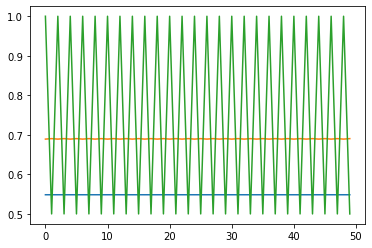

In [23]:
#look at the best evolved individual
#best_genome = np.array([15.546387,-12.697064,13.606401,11.594109,1.562798,-3.227799,-3.208949,-12.919737,6.167427,-9.573342,12.322079,-7.014952,7.277699,2.304232,2.926110])
#duration=500

best_genome = M.fitStats()[2] #genome of best individual
inputarray = np.zeros((3,len(np.arange(0,duration,stepsize))))
division=int(len(inputarray[0])/2)
inputarray[2,division:]=currentstep  #tonic input to the interneuron during the second half of the run
N = CTRNN(3,stepsize)
#N.__init__(3)
A = LeggedAgent(2,stepsize,duration)
weightmatrix = np.reshape(best_genome[:9],(3,3))
multiplier = np.abs(np.fliplr(np.identity(3))-np.ones((3,3))) #keeps absent connections set to zero
weightmatrix = weightmatrix*multiplier
N.setWeights(weightmatrix)
#print("weights=",weights)
N.setBiases(best_genome[9:12])
#print("biases=",best_genome[9:12])
N.setTimeConstants(best_genome[12:15])
#print("ts=",best_genome[12:15])
A.run(duration,N,inputarray)
plt.plot(A.ctrnn_record.T[475:525,:])

Text(0, 0.5, 'Fitness')

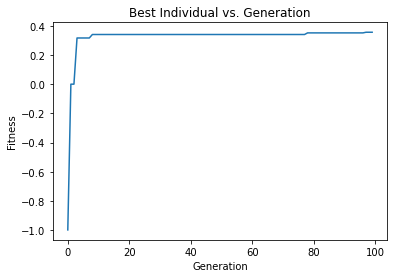

In [25]:
plt.plot(M.bestHistory)
plt.title("Best Individual vs. Generation")
plt.xlabel("Generation")
plt.ylabel("Fitness")

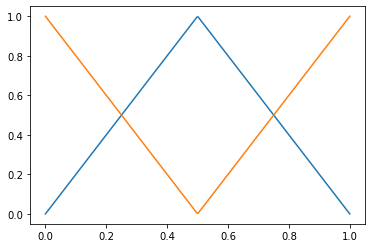

In [77]:
x=np.linspace(0,1,300)
plt.plot(x,(1-2*abs(.5-x)))
plt.plot(x,(2*abs(.5-x)))
